In [16]:
from neural_spline.utils import load_mesh_data
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load 2D polygon data
data = load_mesh_data('simple')
print(f"Data type: {data['type']}")
print(f"Vertices shape: {data['vertices'].shape}")
print(f"Edges shape: {data['edges'].shape}")

  Generating simple convex polygons...
  Mesh vertices: 32, faces: 60
  Polygon vertices: 16, edges: 16
Data type: 2d
Vertices shape: torch.Size([16, 2])
Edges shape: torch.Size([16, 2])


In [17]:
class VoxelSDF2D:
    """
    2D Voxel-based Signed Distance Field for polygons.
    Uses exact analytical SDF computation for line segments.
    """
    
    def __init__(self, vertices, edges, bound=1.0, resolution=64):
        """
        Args:
            vertices: (N, 2) tensor of polygon vertices
            edges: (E, 2) tensor of edge indices
            bound: Domain is [-bound, bound]^2 (default: 1.0)
            resolution: Number of grid cells per axis
        """
        self.vertices = vertices
        self.edges = edges
        self.bound = bound
        self.resolution = resolution
        self.device = vertices.device
        
        # Grid spacing
        self.dx = (2 * bound) / (resolution - 1)
        
        # Create grid
        self._create_grid()
        
        # Build SDF
        self._build_sdf_grid()
    
    def _create_grid(self):
        """Create 2D grid of sample points."""
        x = torch.linspace(-self.bound, self.bound, self.resolution, device=self.device)
        y = torch.linspace(-self.bound, self.bound, self.resolution, device=self.device)
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        self.grid_points = torch.stack([xx, yy], dim=-1)  # (H, W, 2)
    
    def _sdf_point_to_segment(self, point, v0, v1):
        """
        Compute exact signed distance from a point to a line segment.
        
        Args:
            point: (2,) query point
            v0, v1: (2,) segment endpoints
        
        Returns:
            signed_distance: scalar
            normal: (2,) unit normal vector (points away from polygon)
        """
        edge = v1 - v0
        edge_len = torch.norm(edge)
        
        # Degenerate edge
        if edge_len < 1e-10:
            diff = point - v0
            dist = torch.norm(diff)
            if dist < 1e-10:
                return torch.tensor(0.0, device=self.device), torch.tensor([1.0, 0.0], device=self.device)
            return dist, diff / dist
        
        # Edge direction and normal (CCW polygon => normal points outward)
        edge_dir = edge / edge_len
        normal = torch.stack([edge_dir[1], -edge_dir[0]])  # 90° CW rotation
        
        # Project point onto infinite line
        to_point = point - v0
        t = torch.dot(to_point, edge_dir)
        
        # Clamp to segment
        t_clamped = torch.clamp(t, 0, edge_len)
        closest = v0 + t_clamped * edge_dir
        
        # Distance and sign
        diff = point - closest
        dist = torch.norm(diff)
        
        if dist < 1e-10:
            # Point is on the segment
            return torch.tensor(0.0, device=self.device), normal
        
        # Sign: positive if point is on the normal side (outside)
        sign = torch.sign(torch.dot(diff, normal))
        signed_dist = sign * dist
        
        return signed_dist, normal
    
    def _sdf_point_to_polygon(self, point):
        """
        Compute exact signed distance from point to polygon.
        
        Returns:
            min_sdf: scalar signed distance
            best_normal: (2,) normal at closest point
        """
        min_abs_sdf = torch.tensor(float('inf'), device=self.device)
        min_sdf = torch.tensor(float('inf'), device=self.device)
        best_normal = torch.zeros(2, device=self.device)
        
        # Check all edges
        for edge_idx in self.edges:
            v0 = self.vertices[edge_idx[0]]
            v1 = self.vertices[edge_idx[1]]
            
            sdf, normal = self._sdf_point_to_segment(point, v0, v1)
            
            # Keep closest edge
            abs_sdf = torch.abs(sdf)
            if abs_sdf < min_abs_sdf:
                min_abs_sdf = abs_sdf
                min_sdf = sdf
                best_normal = normal
        
        return min_sdf, best_normal
    
    def _sdf_point_to_segment_batch(self, points, v0, v1):
        """
        Compute exact signed distance from points to line segments (vectorized).
        
        Args:
            points: (N, E, 2) query points (broadcasted)
            v0: (1, E, 2) segment start points
            v1: (1, E, 2) segment end points
        
        Returns:
            signed_distances: (N, E) signed distances
            normals: (N, E, 2) unit normal vectors
        """
        # Edge vectors
        edge = v1 - v0  # (1, E, 2)
        edge_len = torch.norm(edge, dim=-1, keepdim=True)  # (1, E, 1)
        
        # Handle degenerate edges
        edge_len = torch.clamp(edge_len, min=1e-10)
        edge_dir = edge / edge_len  # (1, E, 2)
        
        # Edge normal (CCW polygon => normal points outward)
        # 90° CW rotation: (x, y) -> (y, -x)
        normal = torch.stack([edge_dir[..., 1], -edge_dir[..., 0]], dim=-1)  # (1, E, 2)
        
        # Project points onto infinite lines
        to_point = points - v0  # (N, E, 2)
        t = torch.sum(to_point * edge_dir, dim=-1, keepdim=True)  # (N, E, 1)
        
        # Clamp to segment - use min/max with tensors
        t_clamped = torch.maximum(torch.minimum(t, edge_len), torch.zeros_like(t))  # (N, E, 1)
        closest = v0 + t_clamped * edge_dir  # (N, E, 2)
        
        # Distance and sign
        diff = points - closest  # (N, E, 2)
        dist = torch.norm(diff, dim=-1, keepdim=True)  # (N, E, 1)
        
        # Sign: positive if point is on the normal side (outside)
        sign = torch.sign(torch.sum(diff * normal, dim=-1, keepdim=True))  # (N, E, 1)
        sign = torch.where(sign == 0, torch.ones_like(sign), sign)  # Handle zero case
        
        signed_dist = (sign * dist).squeeze(-1)  # (N, E)
        
        # Broadcast normals to all points
        normals = normal.expand(points.shape[0], -1, -1)  # (N, E, 2)
        
        return signed_dist, normals
    
    def _sdf_points_to_polygon_batch(self, points):
        """
        Compute SDF from multiple points to polygon in parallel.
        
        Args:
            points: (N, 2) tensor of query points
            
        Returns:
            min_sdf: (N,) signed distances
            best_normals: (N, 2) normals at closest points
        """
        N = points.shape[0]
        E = self.edges.shape[0]
        
        # Get all edge vertices
        v0 = self.vertices[self.edges[:, 0]]  # (E, 2)
        v1 = self.vertices[self.edges[:, 1]]  # (E, 2)
        
        # Expand dimensions for broadcasting
        points_exp = points.unsqueeze(1)  # (N, 1, 2)
        v0_exp = v0.unsqueeze(0)           # (1, E, 2)
        v1_exp = v1.unsqueeze(0)           # (1, E, 2)
        
        # Vectorized segment distance computation
        # This computes distance from all N points to all E edges
        sdf_matrix, normals_matrix = self._sdf_point_to_segment_batch(
            points_exp, v0_exp, v1_exp
        )  # sdf_matrix: (N, E), normals_matrix: (N, E, 2)
        
        # Find closest edge for each point
        abs_sdf = torch.abs(sdf_matrix)  # (N, E)
        closest_edge_idx = torch.argmin(abs_sdf, dim=1)  # (N,)
        
        # Gather results from closest edges
        batch_indices = torch.arange(N, device=self.device)
        min_sdf = sdf_matrix[batch_indices, closest_edge_idx]  # (N,)
        best_normals = normals_matrix[batch_indices, closest_edge_idx]  # (N, 2)
        
        return min_sdf, best_normals
    
    def _build_sdf_grid(self):
        """Compute SDF and normals at all grid points using vectorized operations."""
        H, W = self.resolution, self.resolution
        
        print(f"Building SDF grid ({H}x{W} = {H*W} points)...")
        
        # Reshape grid points to (H*W, 2) for batch processing
        points = self.grid_points.reshape(-1, 2)  # (H*W, 2)
        
        # Compute distances from all points to all edges in parallel
        sdf_values, normals = self._sdf_points_to_polygon_batch(points)
        
        # Reshape back to grid
        self.sdf_grid = sdf_values.reshape(H, W)
        self.normal_grid = normals.reshape(H, W, 2)
        
        print("SDF grid built successfully!")
    
    def query(self, points):
        """
        Query SDF and normals at arbitrary points using bilinear interpolation.
        
        Args:
            points: (..., 2) tensor of query points
        
        Returns:
            sdf_values: (...,) tensor
            normals: (..., 2) tensor
        """
        original_shape = points.shape[:-1]
        points_flat = points.reshape(-1, 2)
        
        # Convert to grid coordinates [0, resolution-1]
        grid_coords = (points_flat + self.bound) / self.dx
        
        # Bilinear interpolation
        sdf_vals = self._bilinear_interpolate(grid_coords, self.sdf_grid)
        normals = self._bilinear_interpolate(grid_coords, self.normal_grid)
        
        # Normalize normals
        normals = normals / (torch.norm(normals, dim=-1, keepdim=True) + 1e-10)
        
        # Reshape to original shape
        sdf_vals = sdf_vals.reshape(original_shape)
        normals = normals.reshape(*original_shape, 2)
        
        return sdf_vals, normals
    
    def _bilinear_interpolate(self, coords, grid):
        """
        Bilinear interpolation on 2D grid.
        
        Args:
            coords: (N, 2) grid coordinates
            grid: (H, W) or (H, W, C) value grid
        """
        x_coords, y_coords = coords[:, 0], coords[:, 1]
        
        # Grid indices
        x0 = torch.clamp(torch.floor(x_coords).long(), 0, self.resolution - 1)
        x1 = torch.clamp(x0 + 1, 0, self.resolution - 1)
        y0 = torch.clamp(torch.floor(y_coords).long(), 0, self.resolution - 1)
        y1 = torch.clamp(y0 + 1, 0, self.resolution - 1)
        
        # Interpolation weights
        wx = (x_coords - x0.float()).unsqueeze(-1)
        wy = (y_coords - y0.float()).unsqueeze(-1)
        
        # Get corner values
        v00 = grid[x0, y0]
        v01 = grid[x0, y1]
        v10 = grid[x1, y0]
        v11 = grid[x1, y1]
        
        # Scalar grid (H, W)
        if grid.dim() == 2:
            v0 = v00 * (1 - wy.squeeze()) + v01 * wy.squeeze()
            v1 = v10 * (1 - wy.squeeze()) + v11 * wy.squeeze()
            return v0 * (1 - wx.squeeze()) + v1 * wx.squeeze()
        
        # Vector grid (H, W, C)
        else:
            v0 = v00 * (1 - wy) + v01 * wy
            v1 = v10 * (1 - wy) + v11 * wy
            return v0 * (1 - wx) + v1 * wx
    
    def visualize(self, ax=None):
        """Visualize the SDF grid as a heatmap with zero-level contour."""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))
        
        extent = [-self.bound, self.bound, -self.bound, self.bound]
        
        # SDF heatmap
        im = ax.imshow(
            self.sdf_grid.cpu().numpy().T,
            extent=extent,
            origin='lower',
            cmap='RdBu_r',
            vmin=-0.3,
            vmax=0.3
        )
        
        # Zero contour (surface)
        ax.contour(
            self.sdf_grid.cpu().numpy().T,
            levels=[0],
            colors='green',
            linewidths=2,
            extent=extent,
            origin='lower'
        )
        
        # Plot polygon edges
        vertices_cpu = self.vertices.cpu().numpy()
        edges_cpu = self.edges.cpu().numpy()
        for edge in edges_cpu:
            v0, v1 = vertices_cpu[edge[0]], vertices_cpu[edge[1]]
            ax.plot([v0[0], v1[0]], [v0[1], v1[1]], 'k-', linewidth=2, alpha=0.7)
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'VoxelSDF 2D (resolution={self.resolution})')
        ax.set_aspect('equal')
        plt.colorbar(im, ax=ax, label='Signed Distance')
        
        return ax
    
    def __call__(self, points):
        """Alias for query()."""
        return self.query(points)

In [18]:
# Create VoxelSDF with different resolutions
voxel_sdf = VoxelSDF2D(
    vertices=data['vertices'],
    edges=data['edges'],
    bound=1.0,
    resolution=64
)

Building SDF grid (64x64 = 4096 points)...
SDF grid built successfully!


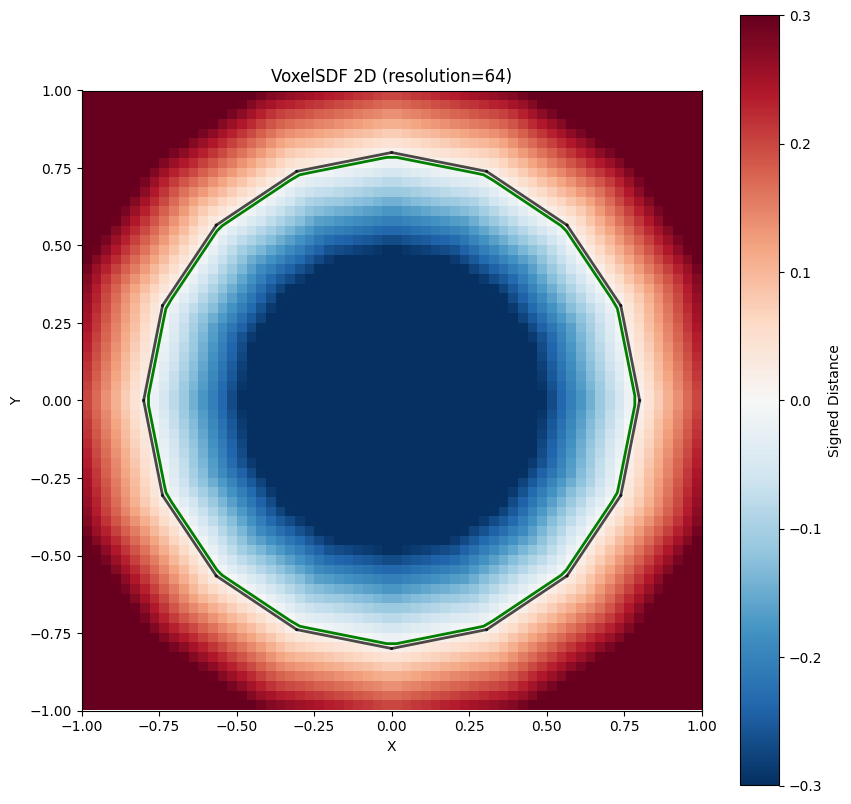

In [19]:
# Visualize the SDF
fig, ax = plt.subplots(figsize=(10, 10))
voxel_sdf.visualize(ax=ax)
plt.show()

In [20]:
# Test querying arbitrary points
test_points = torch.tensor([
    [0.0, 0.0],
    [0.5, 0.0],
    [0.0, 0.5],
    [0.3, 0.3],
], device=data['vertices'].device)

sdf_vals, normals = voxel_sdf.query(test_points)

print("Query Results:")
for i, pt in enumerate(test_points):
    print(f"  Point {pt.cpu().numpy()}: SDF={sdf_vals[i].item():.4f}, Normal={normals[i].cpu().numpy()}")

Query Results:
  Point [0. 0.]: SDF=-0.7626, Normal=[0. 0.]
  Point [0.5 0. ]: SDF=-0.2911, Normal=[1. 0.]
  Point [0.  0.5]: SDF=-0.2911, Normal=[0. 1.]
  Point [0.3 0.3]: SDF=-0.3681, Normal=[0.82064664 0.571436  ]


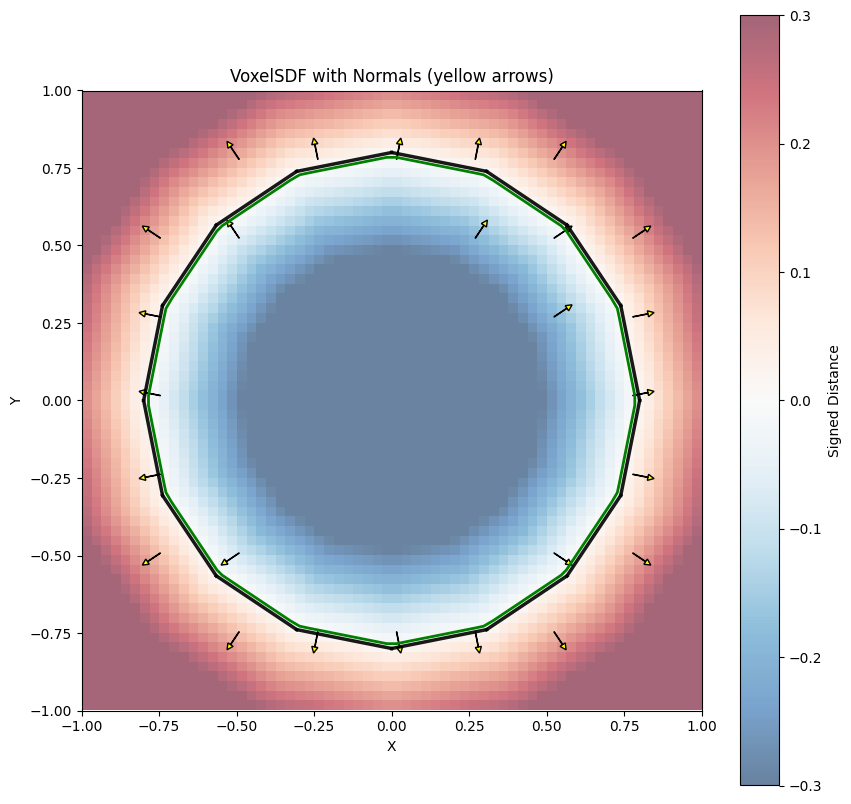

In [21]:
# Visualize normals as arrows on a coarser grid
fig, ax = plt.subplots(figsize=(10, 10))

# Show SDF heatmap
extent = [-voxel_sdf.bound, voxel_sdf.bound, -voxel_sdf.bound, voxel_sdf.bound]
im = ax.imshow(
    voxel_sdf.sdf_grid.cpu().numpy().T,
    extent=extent,
    origin='lower',
    cmap='RdBu_r',
    vmin=-0.3,
    vmax=0.3,
    alpha=0.6
)

# Plot normals on a coarser grid (every 8th point)
stride = 8
for i in range(0, voxel_sdf.resolution, stride):
    for j in range(0, voxel_sdf.resolution, stride):
        point = voxel_sdf.grid_points[i, j].cpu().numpy()
        normal = voxel_sdf.normal_grid[i, j].cpu().numpy()
        sdf = voxel_sdf.sdf_grid[i, j].cpu().numpy()
        
        # Only show normals near the surface
        if abs(sdf) < 0.2:
            scale = 0.05
            ax.arrow(
                point[0], point[1],
                normal[0] * scale, normal[1] * scale,
                head_width=0.02, head_length=0.02,
                fc='yellow', ec='black', linewidth=1
            )

# Plot polygon
vertices_cpu = voxel_sdf.vertices.cpu().numpy()
edges_cpu = voxel_sdf.edges.cpu().numpy()
for edge in edges_cpu:
    v0, v1 = vertices_cpu[edge[0]], vertices_cpu[edge[1]]
    ax.plot([v0[0], v1[0]], [v0[1], v1[1]], 'k-', linewidth=2.5, alpha=0.9)

ax.contour(
    voxel_sdf.sdf_grid.cpu().numpy().T,
    levels=[0],
    colors='green',
    linewidths=2,
    extent=extent,
    origin='lower'
)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('VoxelSDF with Normals (yellow arrows)')
ax.set_aspect('equal')
plt.colorbar(im, ax=ax, label='Signed Distance')
plt.show()